# Caso: Modelo de Predicción de Fuga de Clientes en una empresa de Telecomunicaciones

## **1. Cargar de Modulos**

In [272]:
# Import necessary libs
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')
from scipy import stats

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)


# para componentes principales
from sklearn.preprocessing import StandardScaler

# Para un modelo
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier


## Métricas de los modelos
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score


# Crea una semilla cualesquiera
seed = 2022
np.random.seed(seed)

### **2. Lectura Inicial de base de datos**

In [273]:
## Leemos la data de desarrollo de modelos
dataset = pd.read_csv('../data/raw/Data.csv',sep=',')

In [274]:
# Vemos la dimensionalidad
dataset.shape

(7043, 21)

In [275]:
dataset.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [276]:
dataset

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes


#### A.- Definir el problema de la naturaleza que se tiene a continuación, además de los objetivos de negocio bien definidos.

Nos encontramos ante un problema que esta definido la variable repuesta (Método supervisado) la cual es del tipo categórico por ende lo ubicamos dentro de los problemas de clasificación.

#### Objetivos del Negocio

1. Identificar de manera efectiva los clientes propenso a fuga. Ya que el costo de adquirir nuevos clientes es 6 a 7 veces mayor aproximadamente que retener a uno.

2. Brindar una campaña de retención y/o beneficios para los clientes identificados con propensión a fuga e incluso identificandose a la clase de cliente al que pertenece (premium, clase A, Clase B, etc)

3. Es conveniente identificar la ganancia dejada de percibir por aquellos clientes que fugan y el costo que genera por realizar una campaña de retención solo a este grupo identificado. Se debe cuantificar un taza de fuga que pese a las campañas y/o beneficios persisten en su decisión de fuga. Ello nos ayudará a establecer el beneficio del proyecto para detección de clientes propenso de fuga.

4. La identificación y cuantificicación de costo vs beneficios nos dará tambien la taza de error que podemos manejar en el proyecto y la rentabilidad para la empresa incluyendo las campañas de retención o beneficios.

#### B.- ¿Qué tipo de variables se utilizan en el problema de negocio?

In [277]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [278]:
dataset[['SeniorCitizen']] = dataset[['SeniorCitizen']].astype(object)
dataset[['TotalCharges']] = dataset[['TotalCharges']].apply(pd.to_numeric, errors='coerce')
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   object 
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


Las variables en su mayoria son del tipo categorica (object) y tambien se encuentra variables numericas (int64 y float64)

### 3. AED

#### C.- ¿Desarrollar un pequeño análisis de exploratorio?

In [279]:
# Caracteristicas
print("Number of instances in dataset = {}".format(dataset.shape[0]))
print("Total number of columns = {}".format(dataset.columns.shape[0]))
print("Number of instances unique = {}".format(len(dataset['customerID'].unique())))
print("Colums wise count of null values:-")
print(dataset.isnull().sum())

Number of instances in dataset = 7043
Total number of columns = 21
Number of instances unique = 7043
Colums wise count of null values:-
customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64


Presenta 11 valores perdidos en la variable "TotalCharges"

In [280]:
dataset.describe()

,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7032.000000
mean,32.371149,64.761692,2283.300441
std,24.559481,30.090047,2266.771362
min,0.000000,18.250000,18.800000
25%,9.000000,35.500000,401.450000
50%,29.000000,70.350000,1397.475000
75%,55.000000,89.850000,3794.737500
max,72.000000,118.750000,8684.800000


Para los datos perdidos de la variable "TotalCharges" usaremos  la imputación por la mediana para que no sea vean afectado por los valores extremos.

In [281]:
dataset['TotalCharges'] = dataset['TotalCharges'].fillna(dataset['TotalCharges'].median())
dataset.describe()

,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000
mean,32.371149,64.761692,2281.916928
std,24.559481,30.090047,2265.270398
min,0.000000,18.250000,18.800000
25%,9.000000,35.500000,402.225000
50%,29.000000,70.350000,1397.475000
75%,55.000000,89.850000,3786.600000
max,72.000000,118.750000,8684.800000


In [282]:
## Para variables Cualitativas
def plot_cat(feature):
  sns.countplot(data=dataset,x=feature)
  ax=sns.countplot(data=dataset,x=feature)

#### Análisis Univariado

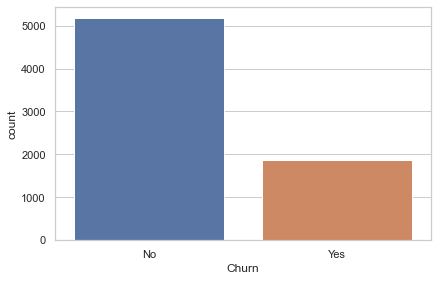

In [283]:
plot_cat('Churn')

In [284]:
## Calculando la proporción
dataset.Churn.value_counts(normalize=True)

No     0.73463
Yes    0.26537
Name: Churn, dtype: float64

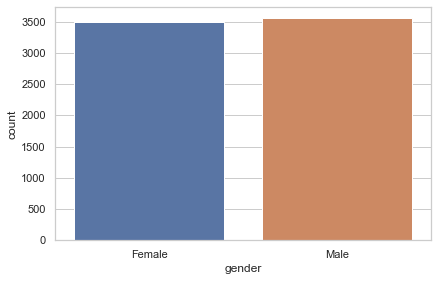

In [285]:
plot_cat('gender')

In [286]:
dataset.groupby('gender').Churn.value_counts(normalize=True).unstack(fill_value=0)

Churn,No,Yes
gender,,
Female,0.730791,0.269209
Male,0.738397,0.261603


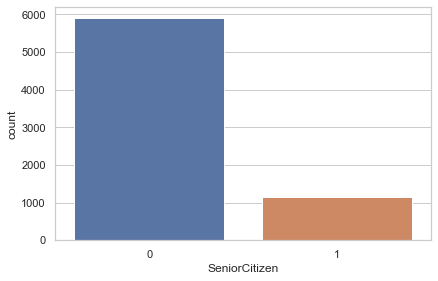

In [287]:
plot_cat('SeniorCitizen')

In [288]:
dataset.groupby('SeniorCitizen').Churn.value_counts(normalize=True).unstack(fill_value=0)

Churn,No,Yes
SeniorCitizen,,
0,0.763938,0.236062
1,0.583187,0.416813


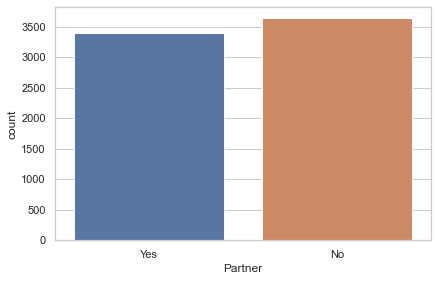

In [289]:
plot_cat('Partner')

In [290]:
dataset.groupby('Partner').Churn.value_counts(normalize=True).unstack(fill_value=0)

Churn,No,Yes
Partner,,
No,0.670420,0.329580
Yes,0.803351,0.196649


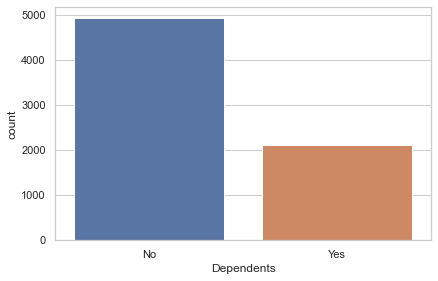

In [291]:
plot_cat('Dependents')

In [292]:
dataset.groupby('Dependents').Churn.value_counts(normalize=True).unstack(fill_value=0)

Churn,No,Yes
Dependents,,
No,0.687209,0.312791
Yes,0.845498,0.154502


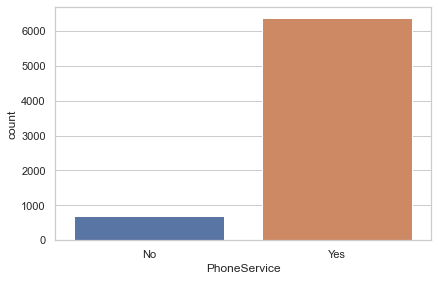

In [293]:
plot_cat('PhoneService')

In [294]:
dataset.groupby('PhoneService').Churn.value_counts(normalize=True).unstack(fill_value=0)

Churn,No,Yes
PhoneService,,
No,0.750733,0.249267
Yes,0.732904,0.267096


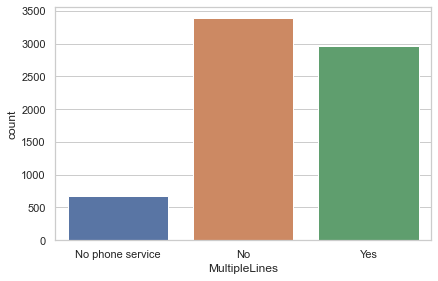

In [295]:
plot_cat('MultipleLines')

In [296]:
dataset.groupby('MultipleLines').Churn.value_counts(normalize=True).unstack(fill_value=0)

Churn,No,Yes
MultipleLines,,
No,0.749558,0.250442
No phone service,0.750733,0.249267
Yes,0.713901,0.286099


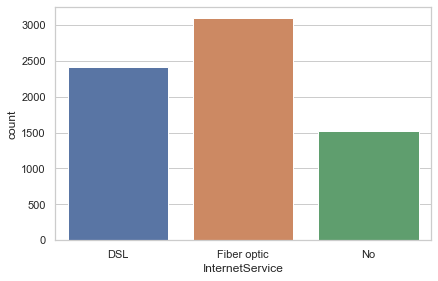

In [297]:
plot_cat('InternetService')

In [298]:
dataset.groupby('InternetService').Churn.value_counts(normalize=True).unstack(fill_value=0)

Churn,No,Yes
InternetService,,
DSL,0.810409,0.189591
Fiber optic,0.581072,0.418928
No,0.925950,0.074050


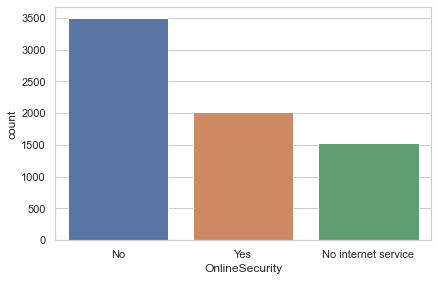

In [299]:
plot_cat('OnlineSecurity')

In [300]:
dataset.groupby('OnlineSecurity').Churn.value_counts(normalize=True).unstack(fill_value=0)

Churn,No,Yes
OnlineSecurity,,
No,0.582333,0.417667
No internet service,0.925950,0.074050
Yes,0.853888,0.146112


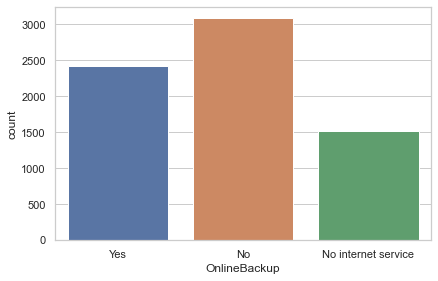

In [301]:
plot_cat('OnlineBackup')

In [302]:
dataset.groupby('OnlineBackup').Churn.value_counts(normalize=True).unstack(fill_value=0)

Churn,No,Yes
OnlineBackup,,
No,0.600712,0.399288
No internet service,0.925950,0.074050
Yes,0.784685,0.215315


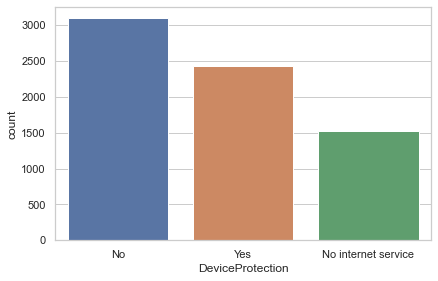

In [303]:
plot_cat('DeviceProtection')

In [304]:
dataset.groupby('DeviceProtection').Churn.value_counts(normalize=True).unstack(fill_value=0)

Churn,No,Yes
DeviceProtection,,
No,0.608724,0.391276
No internet service,0.925950,0.074050
Yes,0.774979,0.225021


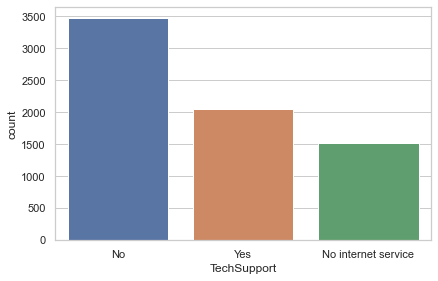

In [305]:
plot_cat('TechSupport')

In [306]:
dataset.groupby('TechSupport').Churn.value_counts(normalize=True).unstack(fill_value=0)

Churn,No,Yes
TechSupport,,
No,0.583645,0.416355
No internet service,0.925950,0.074050
Yes,0.848337,0.151663


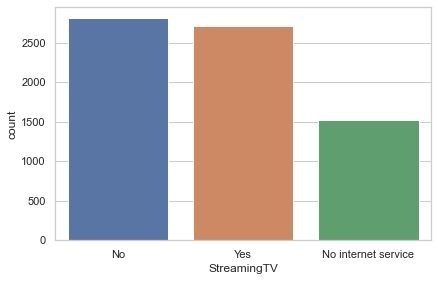

In [307]:
plot_cat('StreamingTV')

In [308]:
dataset.groupby('StreamingTV').Churn.value_counts(normalize=True).unstack(fill_value=0)

Churn,No,Yes
StreamingTV,,
No,0.664769,0.335231
No internet service,0.925950,0.074050
Yes,0.699298,0.300702


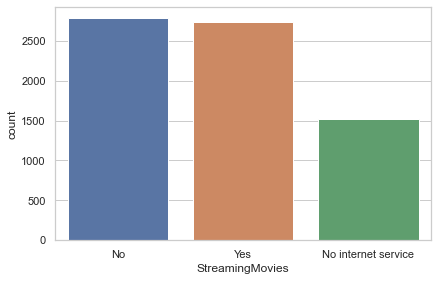

In [309]:
plot_cat('StreamingMovies')

In [310]:
dataset.groupby('StreamingMovies').Churn.value_counts(normalize=True).unstack(fill_value=0)

Churn,No,Yes
StreamingMovies,,
No,0.663196,0.336804
No internet service,0.925950,0.074050
Yes,0.700586,0.299414


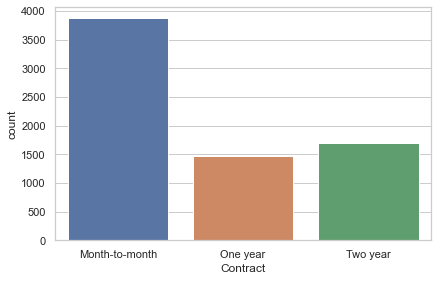

In [311]:
plot_cat('Contract')

In [312]:
dataset.groupby('Contract').Churn.value_counts(normalize=True).unstack(fill_value=0)

Churn,No,Yes
Contract,,
Month-to-month,0.572903,0.427097
One year,0.887305,0.112695
Two year,0.971681,0.028319


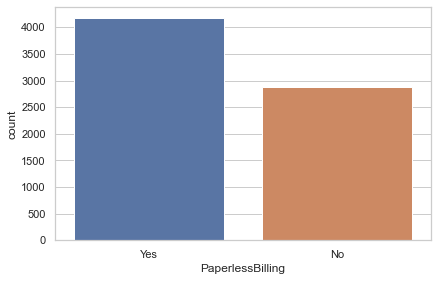

In [313]:
plot_cat('PaperlessBilling')

In [314]:
dataset.groupby('PaperlessBilling').Churn.value_counts(normalize=True).unstack(fill_value=0)

Churn,No,Yes
PaperlessBilling,,
No,0.836699,0.163301
Yes,0.664349,0.335651


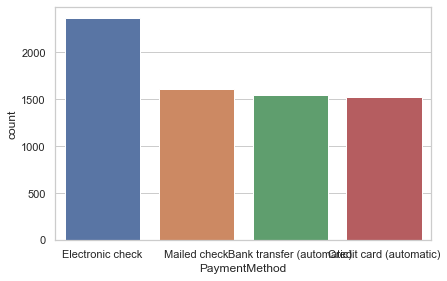

In [315]:
plot_cat('PaymentMethod')

In [316]:
dataset.groupby('PaymentMethod').Churn.value_counts(normalize=True).unstack(fill_value=0)

Churn,No,Yes
PaymentMethod,,
Bank transfer (automatic),0.832902,0.167098
Credit card (automatic),0.847569,0.152431
Electronic check,0.547146,0.452854
Mailed check,0.808933,0.191067


In [317]:
## Para variables cuantitativas
def plot_num(feature):
    fig,axes=plt.subplots(1,2)
    sns.boxplot(data=dataset,x=feature,ax=axes[0])
    sns.distplot(a=dataset[feature],ax=axes[1],color='#ff4125')
    fig.set_size_inches(15,5)

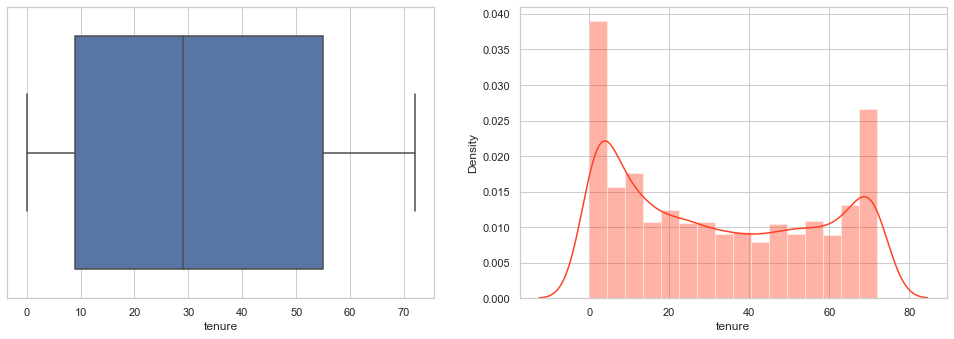

In [318]:
plot_num('tenure')

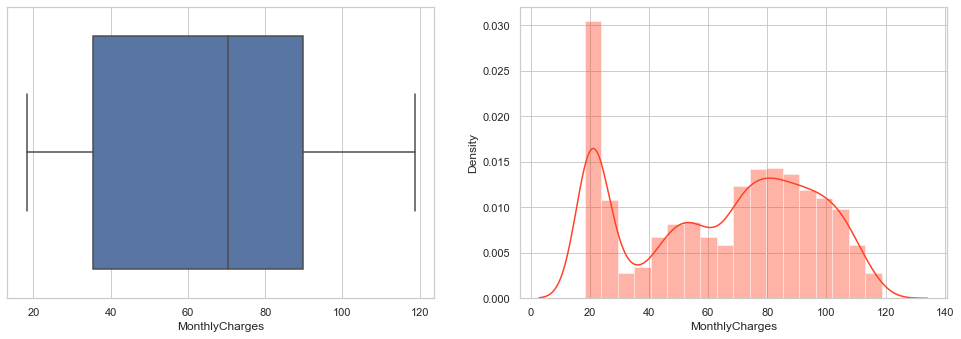

In [319]:
plot_num('MonthlyCharges')

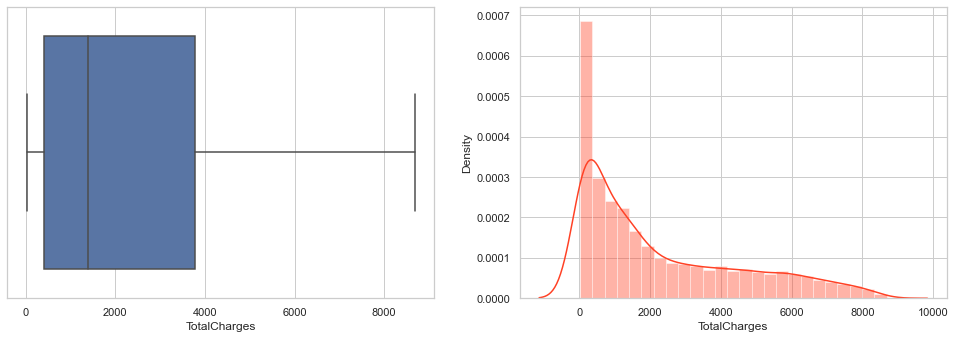

In [320]:
plot_num('TotalCharges')

<AxesSubplot:>

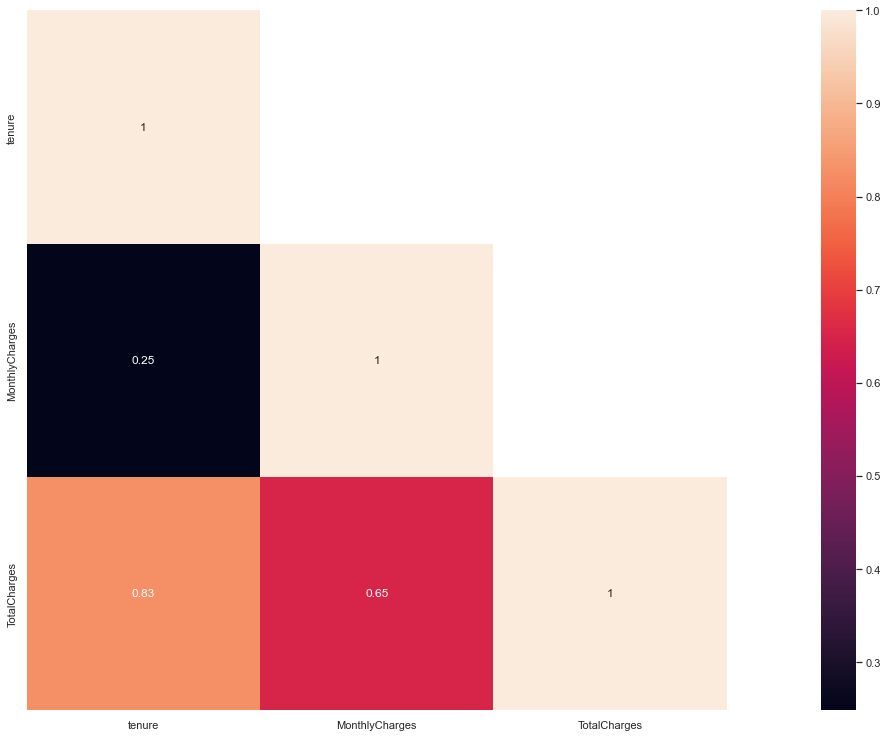

In [321]:
## Matriz de corelaciones
cor_mat = dataset.corr()
mask = np.array(cor_mat)
mask[np.tril_indices_from(mask)] = False
fig = plt.gcf()
fig.set_size_inches(30,12)
sns.heatmap(data=cor_mat,mask=mask,square=True,annot=True,cbar=True)

In [322]:
# Correlaciones de varables
dataset.corr(method='pearson')

,tenure,MonthlyCharges,TotalCharges
tenure,1.000000,0.247900,0.825464
MonthlyCharges,0.247900,1.000000,0.650864
TotalCharges,0.825464,0.650864,1.000000


La variables independientes numericas que tienen una fuerte correlación positiva son: "TotalCharges" y "tenure" es de 0.825, las variables menos relaconadas son "MonthlyCharges" y "tenure" es de 0.247

Las distribuciones de las variables explicativas son asimetricas con colas a la derecha.

### **4. Ingeniería y Selección de Variables**

#### Recodificacion - Label Encoding

In [323]:
from sklearn import preprocessing

## selection of category variables
target = 'Churn'
exclude = ['customerID','Churn']

cols = [x for x in dataset.columns if x not in exclude + [target]]
cols_cat = dataset[cols].select_dtypes(['object']).columns.tolist()
index_categorical=[cols.index(x) for x in cols_cat]
print(exclude, '\n\n', index_categorical,cols_cat)


## For Training
for i in cols_cat:
    le = preprocessing.LabelEncoder()
    le.fit(list(dataset[i].dropna()))
    dataset.loc[~dataset[i].isnull(),i]=le.transform(dataset[i].dropna())

dataset[cols].head()

['customerID', 'Churn'] 

 [0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16] ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,0,0,1,0,1,0,1,0,0,2,0,0,0,0,0,1,2,29.85,29.85
1,1,0,0,0,34,1,0,0,2,0,2,0,0,0,1,0,3,56.95,1889.50
2,1,0,0,0,2,1,0,0,2,2,0,0,0,0,0,1,3,53.85,108.15
3,1,0,0,0,45,0,1,0,2,0,2,2,0,0,1,0,0,42.30,1840.75
4,0,0,0,0,2,1,0,1,0,0,0,0,0,0,0,1,2,70.70,151.65


In [324]:
dataset.to_csv('../data/processed/Data_val.csv')

In [325]:
dataset

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,0,0,1,0,1,0,1,0,0,...,0,0,0,0,0,1,2,29.85,29.85,No
1,5575-GNVDE,1,0,0,0,34,1,0,0,2,...,2,0,0,0,1,0,3,56.95,1889.50,No
2,3668-QPYBK,1,0,0,0,2,1,0,0,2,...,0,0,0,0,0,1,3,53.85,108.15,Yes
3,7795-CFOCW,1,0,0,0,45,0,1,0,2,...,2,2,0,0,1,0,0,42.30,1840.75,No
4,9237-HQITU,0,0,0,0,2,1,0,1,0,...,0,0,0,0,0,1,2,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,1,0,1,1,24,1,2,0,2,...,2,2,2,2,1,1,3,84.80,1990.50,No
7039,2234-XADUH,0,0,1,1,72,1,2,1,0,...,2,0,2,2,1,1,1,103.20,7362.90,No
7040,4801-JZAZL,0,0,1,1,11,0,1,0,2,...,0,0,0,0,0,1,2,29.60,346.45,No
7041,8361-LTMKD,1,1,1,0,4,1,2,1,0,...,0,0,0,0,0,1,3,74.40,306.60,Yes


### **5. Modelamiento de Datos o Creación del Algoritmo de ML**

#### 5.1. Particion Muestral

In [326]:
data = dataset.sample(frac=0.9, random_state=1000)
data_unseen = dataset.drop(data.index)
data.reset_index(inplace=True, drop=True)
data_unseen.reset_index(inplace=True, drop=True)
print('Data for Modeling: ' + str(data.shape))
print('Unseen Data For Predictions: ' + str(data_unseen.shape))

Data for Modeling: (6339, 21)
Unseen Data For Predictions: (704, 21)


##### Aplicar las técnicas de balanceo previamente particionando el dataset en train 80% y 20% en test

In [327]:
from sklearn.model_selection import train_test_split

In [328]:
y=data[target]
X=data.drop(exclude,axis=1)

In [329]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.20,random_state=2022,stratify=y)

In [330]:
y_train.value_counts(normalize=True)

No     0.73733
Yes    0.26267
Name: Churn, dtype: float64

In [331]:
y_test.value_counts(normalize=True)

No     0.737382
Yes    0.262618
Name: Churn, dtype: float64

#### 5.2. Algoritmo Machine Learning: Random Forest con Diferentes Técnicas de Balanceo de Datos

In [332]:
y_train.value_counts(normalize=True)

No     0.73733
Yes    0.26267
Name: Churn, dtype: float64

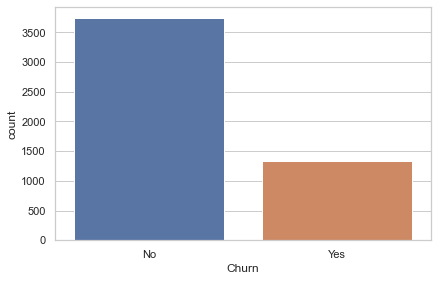

In [333]:
g = sns.countplot(y_train)
g.set_xticklabels(['No','Yes'])
plt.show()

#### Random Under Sampling

In [334]:
# import library
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=2022, replacement=True)
x_rus, y_rus = rus.fit_resample(X_train, y_train)

print('original dataset shape:', Counter(y_train))
print('Resample dataset shape', Counter(y_rus))

original dataset shape: Counter({'No': 3739, 'Yes': 1332})
Resample dataset shape Counter({'No': 1332, 'Yes': 1332})


#### Random Over-Sampling

In [335]:
# import library
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=2022)

# fit predictor and target variablex_ros, 
x_ros, y_ros = ros.fit_resample(X_train, y_train)

print('Original dataset shape', Counter(y_train))
print('Resample dataset shape', Counter(y_ros))

Original dataset shape Counter({'No': 3739, 'Yes': 1332})
Resample dataset shape Counter({'No': 3739, 'Yes': 3739})


#### Synthetic Minority Oversampling Technique (SMOTE)

In [336]:
# import library
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=20)

# fit predictor and target variable
x_smote, y_smote = smote.fit_resample(X_train, y_train)

print('Original dataset shape', Counter(y_train))
print('Resample dataset shape', Counter(y_smote))

Original dataset shape Counter({'No': 3739, 'Yes': 1332})
Resample dataset shape Counter({'No': 3739, 'Yes': 3739})


#### Probar usando el mismo modelo de clasificación que fue Random Forest y validar cual de los 3 tiene el mejor accuracy y la mejor presicion en la clase objetivo que 1

In [337]:
variables =data.iloc[:,1:20].columns
variables

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges'],
      dtype='object')

### Escenario 1: Random Forest Entrenando sin ningún metodo de balanceo 

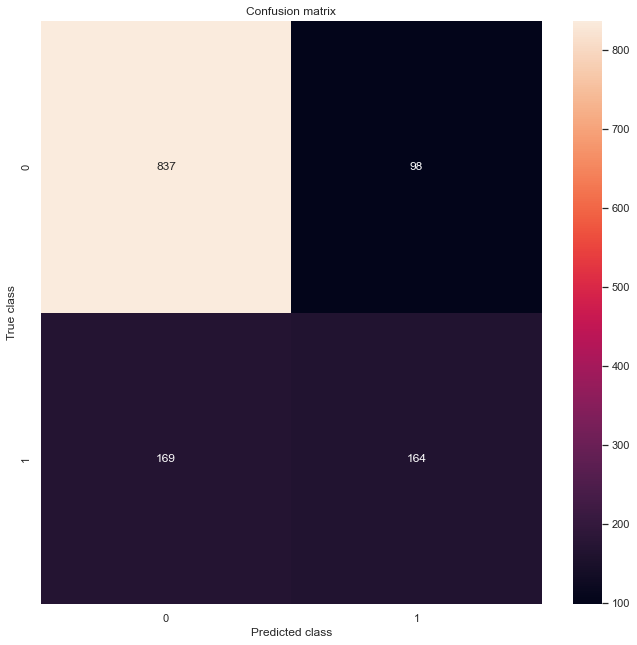

              precision    recall  f1-score   support

          No       0.83      0.90      0.86       935
         Yes       0.63      0.49      0.55       333

    accuracy                           0.79      1268
   macro avg       0.73      0.69      0.71      1268
weighted avg       0.78      0.79      0.78      1268



In [338]:
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

#creamos una función que crea el modelo que usaremos cada vez
def run_model(X_train, X_test, y_train, y_test):
    clf_base = RandomForestClassifier(random_state=2022)
    clf_base.fit(X_train, y_train)
    return clf_base
 
#ejecutamos el modelo "tal cual"
model = run_model(X_train[variables], X_test[variables], y_train, y_test)
 
#definimos funciona para mostrar los resultados
def mostrar_resultados(y_test, pred_y):
    conf_matrix = confusion_matrix(y_test, pred_y)
    plt.figure(figsize=(10, 10))
    sns.heatmap(conf_matrix ,annot=True, fmt="d");
    plt.title("Confusion matrix")
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.show()
    print (classification_report(y_test, pred_y))
 
pred_y = model.predict(X_test[variables])
mostrar_resultados(y_test, pred_y)

In [339]:
# Juntamos el ID con la clase real y la predicha
data = np.hstack((dataset.iloc[y_test.index,0].values.reshape(-1,1),y_test.values.reshape(-1,1), pred_y.reshape(-1,1)))
df_submmit = pd.DataFrame(data, columns=['customerID','Teorico','Prediccion'])
df_submmit.to_csv('test_01_sb.csv', index=False)

#### Escenario 2: Random Forest Entrenando con la técnica de balanceo Under Sampling

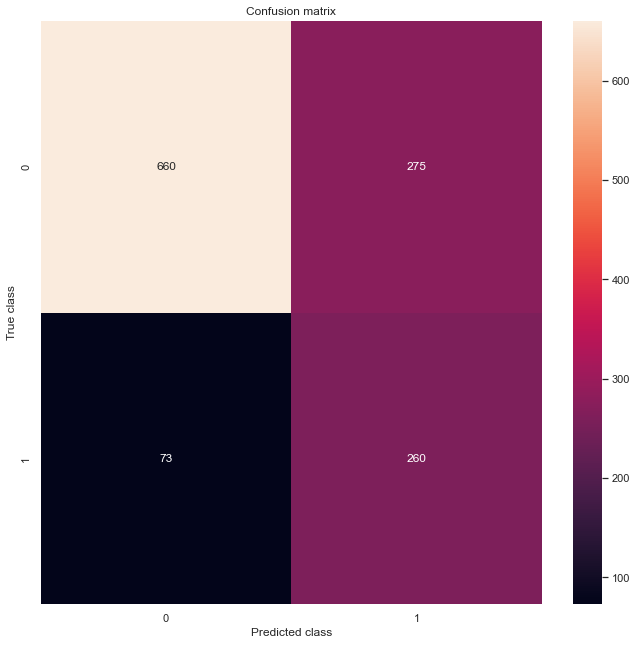

              precision    recall  f1-score   support

          No       0.90      0.71      0.79       935
         Yes       0.49      0.78      0.60       333

    accuracy                           0.73      1268
   macro avg       0.69      0.74      0.70      1268
weighted avg       0.79      0.73      0.74      1268



In [340]:
model_under = run_model(x_rus[variables], X_test[variables], y_rus, y_test)
pred_y = model_under.predict(X_test[variables])
mostrar_resultados(y_test, pred_y)

In [341]:
# Juntamos el ID con la clase real y la predicha
data = np.hstack((dataset.iloc[y_test.index,0].values.reshape(-1,1),y_test.values.reshape(-1,1), pred_y.reshape(-1,1)))
df_submmit = pd.DataFrame(data, columns=['customerID','Teorico','Prediccion'])
df_submmit.to_csv('test_02_us.csv', index=False)

#### Escenario 3: Random Forest Entrenando con la técnica de balanceo Over Sampling

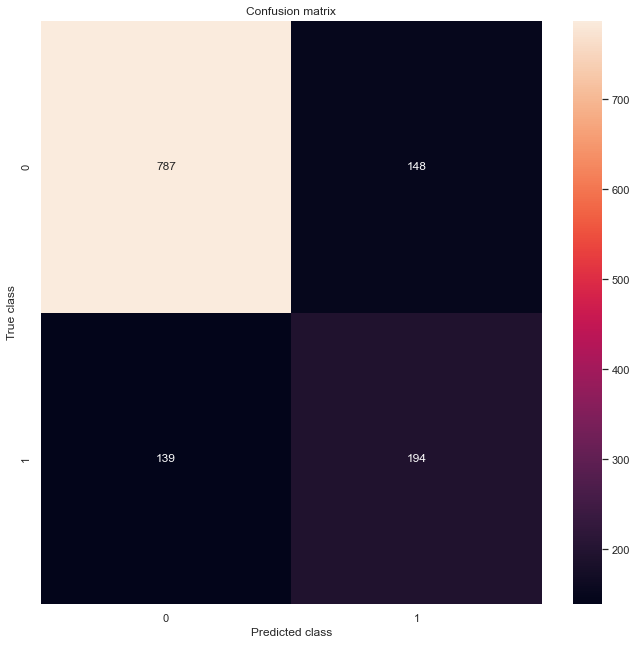

              precision    recall  f1-score   support

          No       0.85      0.84      0.85       935
         Yes       0.57      0.58      0.57       333

    accuracy                           0.77      1268
   macro avg       0.71      0.71      0.71      1268
weighted avg       0.78      0.77      0.77      1268



In [342]:
model_over = run_model(x_ros[variables], X_test[variables], y_ros, y_test)
pred_y = model_over.predict(X_test[variables])
mostrar_resultados(y_test, pred_y)

In [343]:
# Juntamos el ID con la clase real y la predicha
data = np.hstack((dataset.iloc[y_test.index,0].values.reshape(-1,1),y_test.values.reshape(-1,1), pred_y.reshape(-1,1)))
df_submmit = pd.DataFrame(data, columns=['customerID','Teorico','Prediccion'])
df_submmit.to_csv('test_03_os.csv', index=False)

#### Escenario 4: Random Forest Entrenando con la técnica de balanceo SMOTE

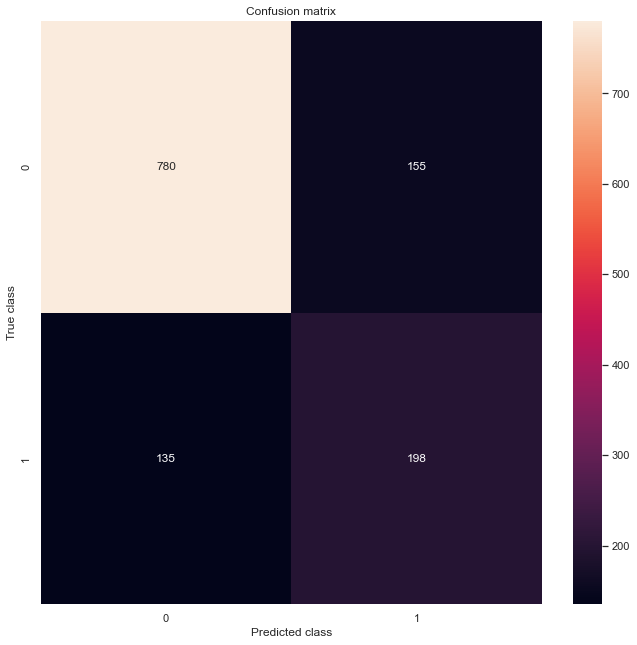

              precision    recall  f1-score   support

          No       0.85      0.83      0.84       935
         Yes       0.56      0.59      0.58       333

    accuracy                           0.77      1268
   macro avg       0.71      0.71      0.71      1268
weighted avg       0.78      0.77      0.77      1268



In [344]:
model_smote = run_model(x_smote[variables], X_test[variables], y_smote, y_test)
pred_y = model_smote.predict(X_test[variables])
mostrar_resultados(y_test, pred_y)

In [345]:
# Juntamos el ID con la clase real y la predicha
data = np.hstack((dataset.iloc[y_test.index,0].values.reshape(-1,1),y_test.values.reshape(-1,1), pred_y.reshape(-1,1)))
df_submmit = pd.DataFrame(data, columns=['customerID','Teorico','Prediccion'])
df_submmit.to_csv('test_04_smote.csv', index=False)

La que presenta un mejor accuracy (0.77) es usando el metodo de balanceo Over Sampling y una precisión (0.57) sobre la clase 1. Es importante mencionar que seguido bastante de cerca por el metodo de balanceo SMOTE.

Resalta tambien que la datatrain sin necesidad de balancear presenta un accuracy y una presición de la clase 1 bastante buenos. Ello se debe a que la data no presenta un desbalanceo tan alto la relación esta 0.27 : 0.63. 

### 6. Evaluación de Modelos

In [346]:
# Guardamos el mejor modelo entrenado para usarlo en la implementación
import pickle
filename = 'bestmodel.pkl'
pickle.dump(model_over, open(filename, 'wb'))

### 7. Scoring del Modelo

#### Todo lo realizado en el dataset de entrenamiento del modelo lo debemos replicar en el dataset de scoring

In [347]:
data_unseen.shape

(704, 21)

In [348]:
data_unseen.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,3668-QPYBK,1,0,0,0,2,1,0,0,2,...,0,0,0,0,0,1,3,53.85,108.15,Yes
1,7469-LKBCI,1,0,0,0,16,1,0,2,1,...,1,1,1,1,2,0,1,18.95,326.80,No
2,3655-SNQYZ,0,0,1,1,69,1,2,1,2,...,2,2,2,2,2,0,1,113.25,7895.15,No
3,1066-JKSGK,1,0,0,0,1,1,0,2,1,...,1,1,1,1,0,0,3,20.15,20.15,Yes
4,8665-UTDHZ,1,0,1,1,1,0,1,0,0,...,0,0,0,0,0,0,2,30.20,30.20,Yes


In [349]:
# Una vez que tenemos todas las variables podemos scorear o puntuar los registros

# Leemos el modelo entrenado!
import pickle
filename = 'bestmodel.pkl'
mod_seg = pickle.load(open(filename, 'rb'))

In [351]:
# Predecimos sobre el set de datos de implementacion con el modelo entrenado
score_final=mod_seg.predict(data_unseen.drop(['customerID','Churn'],axis=1))

In [352]:
score_final.size

704

In [353]:
# Juntamos el ID con la clase
data = np.hstack((data_unseen['Churn'].values.reshape(-1,1), score_final.reshape(-1,1)))
# Le asignamos nombres a las columnas
df_submmit = pd.DataFrame(data, columns=['Churn','Prob'])
# Exportamos la solucion
df_submmit.to_csv('valida_scoring.csv', index=False)